This notebook is for calculating the ro-vibrational line density of a circular slab model of a protoplanetary disk. This notebook generates a 2D circular slab model of a desired temperature and density profile, a desired size, a desired stellar mass, and a desired system inclination.

This analysis code is part of a larger analysis code that is being implemented on simulation data from Dr. Jeffrey Fung'S PEnGUIn code (Github Link: https://github.com/fakesuji/PEnGUIn).

Below, is a list of functions that load necessary spectrum and partition function data, create a 2D circular slab disk with a grid, densities, and velocities, centers the cells from 2D grid points to cell centers, find and match the appropriate partition function value for each cell based of the cell's temperature, calculate the emmitted flux of the disk from a range of ro-vibrational transitions of 12C16O, and calculate the visible intensity we recieve of this flux.

In [122]:
def load_spec_data():
    # Load 12C16O spectrum data
    spec_data = io.BytesIO(requests.get('https://osf.io/t7v8s/download').content).read().decode('utf-8').split('\n')

    # Initialize arrays
    vel_j = []
    ein_j = []
    eng_j = []
    g1j = []
    g0j = []

    # Process each line in spec_data
    for line in spec_data:
        co_data = line.split()
        if len(co_data) > 1:  # Check if the line is not empty
            vel_j.append(float(co_data[1]))
            ein_j.append(float(co_data[2]))
            eng_j.append(float(co_data[3]))
            g1j.append(float(co_data[8]))
            g0j.append(float(co_data[9]))

    print("Spectrum Data Loaded")

    # Load the thermal data
    part_data = io.BytesIO(requests.get('https://osf.io/5g6wm/download').content).read().decode('utf-8').split('\n')

    # Initialize arrays
    temp = []
    part = []

    # Process each line in part_data
    for line in part_data:
        part_line = line.split()
        if len(part_line) > 1:  # Check if the line is not empty
            temp.append(float(part_line[0]))
            part.append(float(part_line[1]))

    print("Thermal Data Loaded")

    return vel_j, ein_j, eng_j, g1j, g0j, temp, part


def load_circular_2d():
    # Creates and returns circular slab model
    x_len   = 2160    #x-dir (radial) grid size
    y_len   = 1200    #y-dir (azimuthal) grid size
    lengths = x_len, y_len

    radius = np.zeros((x_len,y_len))
    theta  = np.zeros((x_len,y_len))

    rad = np.linspace(R_IN, R_OUT, x_len)    #creates radial range
    the = np.linspace(0.0, 2*np.pi, y_len)   #creates theta range

    #these for loops create radial and azimuthal grids
    for i in range(0,x_len):
        for j in range(0,y_len):
            radius[:,j] = rad
            theta[i,:]  = the

    radius = np.transpose(radius)    #correcting the shape of grid
    theta  = np.transpose(theta)
    radius = cell_center_2D(radius)  #centering the grid on centers from points
    theta  = cell_center_2D(theta)
    grids  = radius, theta

    temp    = T0 * (radius/R_IN)**ALPHA   #creates grid surface temperature
    density = N0 * (radius/R_IN)**BETA    #creates grid surface density
    vel     = np.sqrt(G * MASS_STAR / (radius*AU_CM)) * np.sin(theta) * np.sin(INCLIN) / 100000   #creates inclined velocity surface
    data    = density, temp, vel

    return grids, lengths, data


def cell_center_2D(xa):
    #centers grid cells from points to cell centers
    x, y = np.shape(xa)
    Nx = x-1
    Ny = y-1
    xc = np.zeros((Nx,Ny),dtype=np.float64)

    for i in range(Nx):
        for j in range(Ny):
            xc[i,j] = (xa[i+1,j+1]+xa[i,j])/2.0
    return xc


def part_func_1D(temp, part, x_len):
    #generates 1d partion function grid from 1d radial temperatures
    part_func = np.zeros((np.shape(temp)))
    for i in range(0, x_len-1):
        if temp[0,i] > 8999.0:
            #high temperature catch
            part_func[:,i] = part[-1]
        else:
            part_func[:,i] = part[int(temp[0,i])]
    return part_func

def flux_cal(density, vel_j, ein_j, eng_j, g1j, g0j, temp, part_func):
    #calculates the flux of the disk for given transition lines
    constant1 = 1 / (8 * B_CGS * (np.pi)**(3./2.))
    x, y      = np.shape(density)
    optical_t = np.zeros((len(g0j), x, y))
    flux_dens = np.zeros((x, y))

    for i in range(len(g0j)):
        #loops through the different transitions
        opt_depth        = (density / part_func)  * np.exp(-eng_j[i] / (BOLTZ * temp)) * (ein_j[i] * g0j[i]**2 / (g1j[i] * vel_j[i]**3)) * constant1  #optical depth calculation
        planck_func      = (2 * PLANCK * C * vel_j[i]**3) / (np.exp((PLANCK * C * vel_j[i])/(BOLTZ_CGS * temp)) - 1) #planck function calculation
        flux_dens       += (1-np.exp(-opt_depth.astype(float))) * vel_j[i]/ C * planck_func   #flux density calculation
    return flux_dens


def int_j_cal(flux_dens, radius, k_vel, vzp):
    #line density calculation
    int_j = np.zeros(np.shape(k_vel))
    constant2 = 1 / (B_CGS * np.sqrt(np.pi))

    flux_radius = flux_dens * radius**2 * AU_KM
    for i in range(len(k_vel)):
        #loops through the test speeds
        int_j[i] = np.sum(flux_radius * constant2 * np.exp(-(k_vel[i] - vzp)**2 / B**2))
    return int_j

Below is a list of functions that plot various information such as the surface denties or densities profile, the surface temperatures or temperature profile, the observed inclined velocities, or combinations of them.

In [123]:
def plot_line(int_j):
    #plot ro-vibrational line density

    max_int_j = np.max(int_j)      #normalize calculated line to peak at 1
    int_j     = int_j / max_int_j

    fig, ax = plt.subplots()
    ax.plot(k_vel,int_j)
    ax.set_xlim(-150,150)
    plt.xlabel("Velocity [km/s]")
    plt.ylabel("Normalized Flux")
    plt.title("Line Density")
    return

def plot_pol_dens(radius, theta, density):
    #Polar Density Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))
    ax.grid(False)
    plt.pcolormesh(theta, radius, np.log10(density))
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)   # Move radial labels away from plotted line
    plt.colorbar(label="[log(cm-2)]")
    ax.set_title("Calculated Densities")
    return


def plot_pol_vzp(radius, theta, vzp):
    #Polar Inclined Velocity Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.grid(False)
    plt.pcolormesh(theta, radius, vzp, vmin=-150.0, vmax=150.0)
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    plt.colorbar(label="[km/s]")
    ax.set_title("Projected Velocities")
    return


def plot_line_dens(radius, theta, density, int_j):

    max_int_j = np.max(int_j)       #normalize calculated line to peak at 1
    int_j     = int_j / max_int_j

    #Multi Plot - polar density and line
    fig = plt.figure(figsize=(12, 5))
    ax0 = plt.subplot(121, projection='polar')
    ax1 = plt.subplot(122)

    fig.suptitle('Orbit ', fontsize=16)

    ax0.grid(False)
    cset0 = ax0.pcolormesh(theta, radius, np.log10(density))
    ax0.set_ylim(0,0.3)
    ax0.set_rticks([0.1, 0.2, 0.3])
    ax0.set_title("Calculated Densities", fontsize=15)

    ax1.plot(k_vel, int_j)
    ax1.set_xlabel("Velocities [km/s]", fontsize=12)
    ax1.set_ylabel("Normalized Flux",   fontsize=12)
    ax1.set_xlim(-150,150)

    fig.colorbar(cset0, ax=ax0, label="[log(cm-2)]")
    ax1.set_title("Line Density", fontsize=15)
    return

def plot_pol_temp(radius, theta, temp):
    #Polar Temperature Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.grid(False)
    plt.pcolormesh(theta, radius, temp)
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    plt.colorbar(label="[k]")
    ax.set_title("Surface Temperature of Disk")
    return

def plot_temp(radius, temp):
    #Polar Temperature Profile

    fig, ax = plt.subplots()
    plt.plot(radius[0,:], temp[0,:])
    plt.xlabel("Radius [au]")
    plt.ylabel("Temperature [k]")
    ax.set_title("Surface Temperature of Disk")
    return


def plot_dens(radius, dens):
    #Polar Density Profile

    fig, ax = plt.subplots()
    plt.plot(radius[0,:], dens[0,:])
    plt.yscale("log")
    plt.xlabel("Radius [au]")
    plt.ylabel("Density [log10(1/cm^2)]")
    ax.set_title("Surface Density of Disk")
    return

This block below sets the proper conditions for a run, ie the mass of the star, MASS_STAR, the inclination of the disk, INCLIN, the inner radial temperature and the temperature power law constant, T0 and ALPHA, the inner radial density and the density power law constant, N0 and BETA, the inner and outer radial bounds, R_IN and R_OUT, and the Gaussian Spread Constant, B. These are the only parameters that should be change for running this notebook and are located under the comment "system constants to edit".

The rest of this block imports necessary python modelules and defines a range of constants needed for the calculations of this notebook.

In [124]:
"""
Author:  Cory Padgett
Advisor: Dr. Jeffrey Fung
Email:   cpadge4@clemson.edu
"""

#imports
import io
import numpy as np
import matplotlib.pyplot as plt
import requests


#-------------------------------------------------------------------------------------------------------
#constants
#-------------------------------------------------------------------------------------------------------
#system constants to edit
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------
MASS_STAR   = 1.02 * 1.989 * 10**33   #mass of star [g]
INCLIN  = np.radians(71.0)      #inclination of disk [radians]
T0      = 2770           #initial temperature [K]
ALPHA   = -0.33          #temperature power law constant
N0      = 1.0E19         #initial density [1/cm^2]
BETA    = -2.0           #density power law constant
R_IN    = 0.048          #inner radius [au]
R_OUT   = 0.898          #outer radius [au]
B       = 8.8            #gaussian spread constant [km/s]
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

#general constants
PLANCK     = 6.626068 * 10**(-27)      #erg s       Planck’s Constant
BOLTZ      = 0.6950348                 #cm^-1 K^-1  Boltzman’s Constant
BOLTZ_CGS  = 1.380649 * 10**(-16)      #erg K^-1  Boltzman’s Constant
C          = 2.997925 * 10**10         #cm s^-1     Speed of light in vacuum
G          = 6.674 * 10**(-8)          #cm^3 g^−1 s^−2
R          = 8.31446261815324 * 10**7  #erg K^-1 mol^-1
MOL        = 6.022 * 10*23
AU_CM      = 1.496 * 10**13     #cm
AU_KM      = 1.496 * 10**8      #km
MASS_SOL   = 1.989 * 10**33     #g
MASS_JUP   = 1.898 * 10**30     #g
B_CGS      = B * 100000         #cm/s

#arrays
k_vel = np.linspace(-300,300,601)      #velocity space to test [km/s]


The cell below callls a function to load the 12C16O spectrum data as well as its partition function data. This cell also has a function which will create and return a 2D circular slab disk with its grid, shape, and the density, temperature, and observed inclined velocities of this desired disk.

The temperature profile is defined as:
\begin{align}
\mathrm{T(r)} =  T_0 \left(\frac{r}{r_{in}}\right)^{α}
\end{align}
where $\mathrm{T_0}$ is the inner radial temperature, $\mathrm{r_{in}}$ is the inner radius, and $\mathrm{\alpha}$ is the power law constant.

The temperature profile is defined as:
\begin{align}
\mathrm{N(r)} =  N_0 \left(\frac{r}{r_{in}}\right)^{β}
\end{align}
where $\mathrm{N_0}$ is the inner radial temperature, $\mathrm{r_{in}}$ is the inner radius, and $\mathrm{\beta}$ is the power law constant.

The Inclined Projected Velocities of the disk that are being observed are defined as:
\begin{align}
\mathrm{V_p(r,θ)} =  V_k(r) \sin{θ}\sin{i}
\end{align}
where $\mathrm{V_k(r)}$ is the radial Keplarian Speed, $\mathrm{\sin{θ}}$ is the azimuthial direction contribution, and $\mathrm{\sin{i}}$ is the inclination contribution to the Project Velocities.

In [125]:
#load spectrum data
vel_j, ein_j, eng_j, g1j, g0j, temp, part = load_spec_data()

#load circular slab model
grids, lengths, data = load_circular_2d()
radius, theta = grids
x_len, y_len  = lengths
density, temp, vel = data

Spectrum Data Loaded
Thermal Data Loaded


The vast bulk of calculations is carried out in the three functions below. To give context to what is occuring in these functions, below is an outline of the mathematical steps that are being carried out in the functions flux_cal and int_j_cal.

If we assume thermodynamic equilibrium in the disk, the populations of the ro-vibrational states are then:
\begin{align}
\mathrm{N_J} =  \frac{N g_j}{Q(T)} e^{\frac{-E_j}{k_b T}}
\end{align}
where $\mathrm{N}$ is the cell density, $\mathrm{Q(T)}$ is the partition function of temperature for 12C16O for that cell, and $\mathrm{E_J}$ and $\mathrm{g_J}$ are the energy and degeneracy of the $\mathrm{J^{th}}$ state.

The optical depth of these states are then defined as:
\begin{align}
\mathrm{\tau_J} =  \frac{N_J}{8 b \pi^{3/2}} \frac{g_j A_j}{g'_j \tilde{v}^3_j}
\end{align}
where $\mathrm{A_J}$ is the Einstien coeffiecent and $\mathrm{\tilde{v}_J}$ is the central wavenumber for the $\mathrm{J^{th}}$ state. The prime on $\mathrm{g'_J}$ represents the adjacent $\mathrm{J^{th}}$ state.

The flux defined for the $\mathrm{J^{th}}$ state is as follows:
\begin{align}
\mathrm{F_J} =   (1-e^{-\tau_J}) \frac{\tilde{v}_j}{c} B_J(\tilde{v}_J,T)
\end{align}
where $\mathrm{B_J(\tilde{v}_J,T)}$ is the Planck function  in wavenumber expression. The fraction $\mathrm{\frac{\tilde{v}_j}{c}}$ coverts the units into Doppler-shifted velocties.

Finally, we create the line density profile by evaluating the emission flux from every grid cell with a normalized Gaussian Spread Profile G and sum this for every grid cell.
\begin{align}
\mathrm{I_J(V)} =   \sum F_J G(V-V_p) r^2
\end{align}

In [126]:
#----------------------------------------------------------------------------------------------
#Line Desnsity Calculation
#----------------------------------------------------------------------------------------------
part_func = part_func_1D(temp, part, y_len)
flux_dens = flux_cal(density, vel_j, ein_j, eng_j, g1j, g0j, temp, part_func)
int_j     = int_j_cal(flux_dens, radius, k_vel, vel)
print("Calculations Done!")

<ipython-input-122-afc4bf50641b>:108: RuntimeWarning: divide by zero encountered in divide
  opt_depth        = (density / part_func)  * np.exp(-eng_j[i] / (BOLTZ * temp)) * (ein_j[i] * g0j[i]**2 / (g1j[i] * vel_j[i]**3)) * constant1  #optical depth calculation


Calculations Done!


Here below, we call a function to plot the surface density and the line density of the circular slab model of the disk.

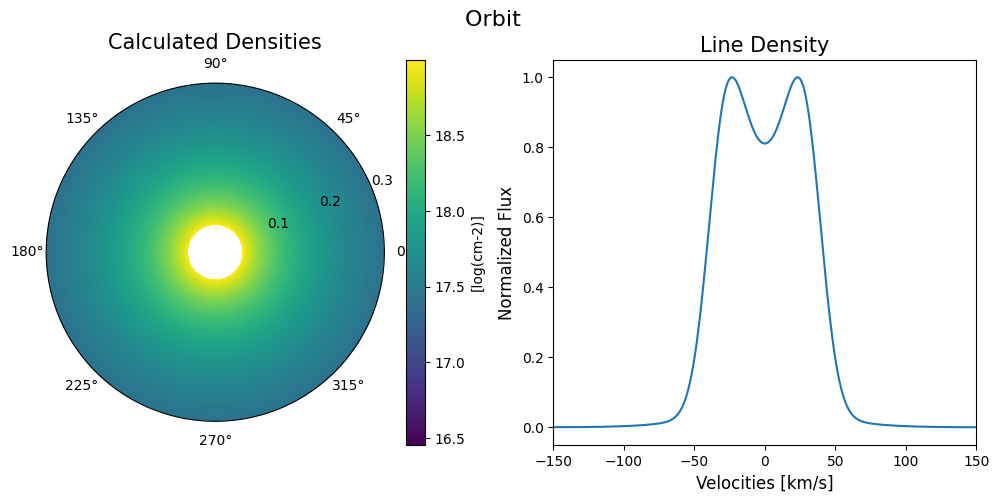

In [127]:
#----------------------------------------------------------------------------------------------
#Plotting
#----------------------------------------------------------------------------------------------
plot_line_dens(radius, theta, density, int_j)

Here below, we call a function to plot the line density of the circular slab model of the disk.

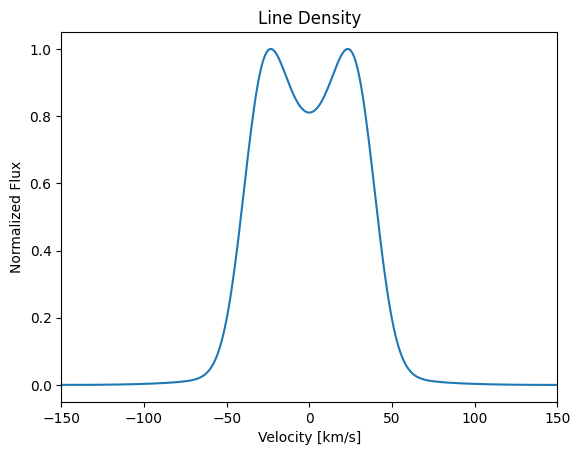

In [129]:
plot_line(int_j)

Here below, we call a function to plot the surface inclined velocities of the circular slab model of the disk.

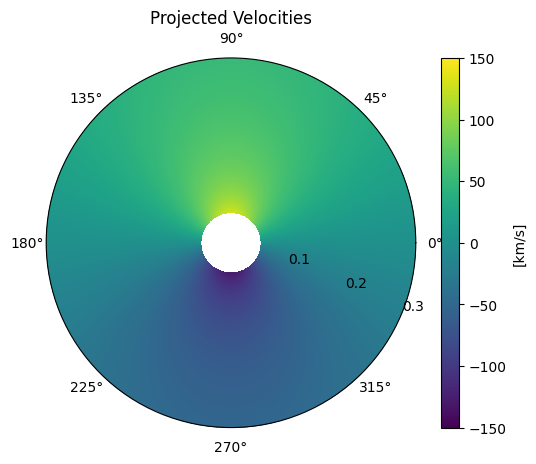

In [131]:
plot_pol_vzp(radius, theta, vel)

Here below, we call a function to plot the surface density of the circular slab model of the disk.

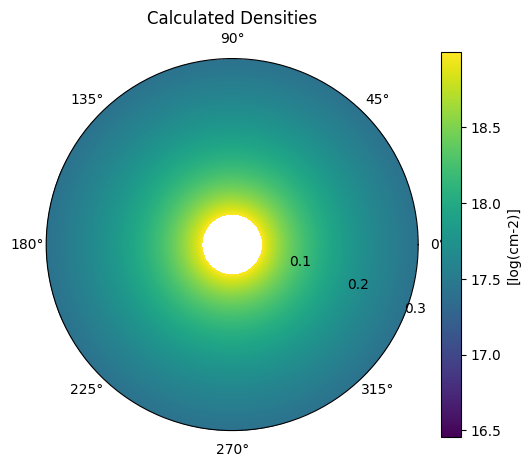

In [133]:
plot_pol_dens(radius, theta, density)

Here below, we call a function to plot the density profile of the circular slab model of the disk.

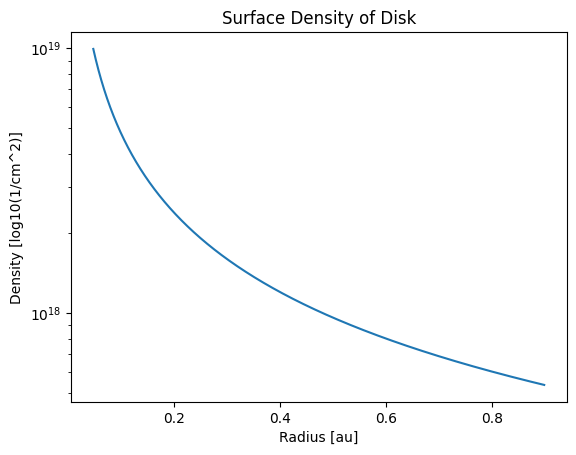

In [135]:
plot_dens(radius, density)

Here below, we call a function to plot the surface temperature of the circular slab model of the disk.

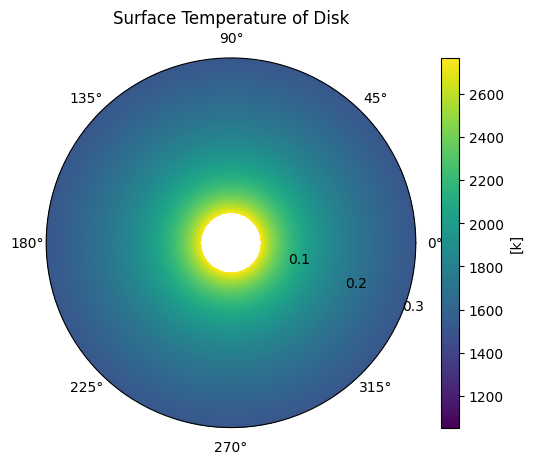

In [137]:
plot_pol_temp(radius, theta, temp)

Here below, we call a function to plot the temperature profile of the circular slab model of the disk.

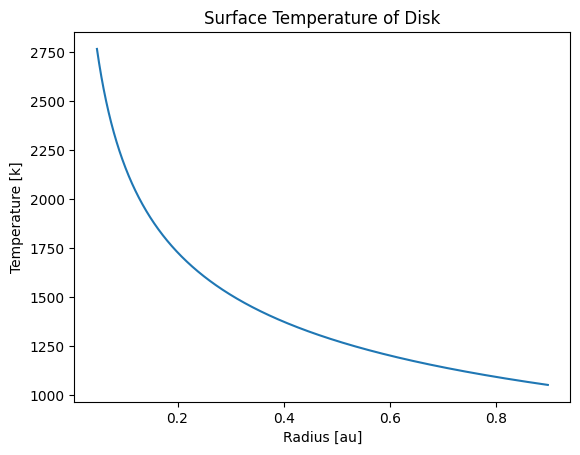

In [139]:
plot_temp(radius, temp)

From these produced figures, we see a symmetric line profile telling us that the disk is of a constant values across the azimuth (only varied in the radial).

If we raise/lower the inner temperature value, we see theline density slightly widen/narrows on the high velocity wings as well as a raising/lowering of the peaks without the y-axis normalization. If we flatten the temperature profile, we see the line become steeper while if we make the profile steeper we widen the line profile.

If we raise/lower the inner density value, we see the line density slightly widen/narrows on the high velocity wings as well as a raising/lowering of the peaks without the y-axis normalization. If we flatten the density profile, we see the line become steeper while if we make the profile steeper we widen the line profile.

If we lower the inclination of the disk, we will make the line density profile narrower while raising will widen the profile.

If we were to lower/raise the Gaussian Spread Constant, B, we would see the line density profile narrow/widen on the peaks.

If we were to lower the inner radial boundary, we would allow for more material that is moving faster contribute to the line density. This would widen the wings of the profile. If we were to raise the outer radial boundary, we would allow for more slower moving material, which would raise the central well between the two peaks.